### Getting Started with Time-Series Monitoring in the Planetary Computer

<details>
<summary><strong>📘 Outline</strong></summary>

1. Introduction  
2. Learning Objectives  
3. Core Concepts
4. Environment configuration
4. Load/Define Your Area of Interest  
5. Define Monitoring Conditions  
6. Query the Planetary Computer's STAC Catalog  
7. Apply NDSI Index  
8. Visualize Time Series  
9. Explore and Adjust Parameters  
10. Export Results  
11. What's Next  

</details>

Monitoring landscapes over time can help detect crop stress, measure snow cover changes, or identify wildfire recovery. This notebook is your starting point for learning how to track those changes using Microsoft’s Planetary Computer platform. In this foundational notebook, you'll define an area of interest, query satellite imagery from the Open Planetary Computer (OPC), apply indices like NDVI, and identify changes across a time series.
The goal is to help you understand key remote sensing concepts and build hands-on skills for real-world geospatial monitoring.

➡️ Next notebooks in this series:
- [Vegetation Monitoring (Intermediate)](/tutorials/site-monitoring-hls.ipynb)
- [Route Monitoring for Extreme Weather Events (Advanced)](/tutorials/climate-risk.ipynb)

### Learning Objectives

By the end of this notebook, you should be able to:

- 🧭 **Understand the purpose** of satellite-based site monitoring.
- 🛰 **Define and import an Area of Interest (AOI)** for analysis.
- 📦 **Retrieve** Earth observation data using the STAC API.
- 🧮 **Calculate** remote sensing indices (like NDVI) to track change.
- 📈 **Visualize and interpret** changes in in your data over time.
- 🔍 **Detect** significant changes using thresholds or time-series trends
- 🛠 **Export your results** to resuse in tools like Fabric or Power BI.

### Core Concepts

Before we begin, here are a few key concepts we'll use in this notebook:

- **Raster data**: Satellite imagery is made up of pixels (grids), each with numeric values representing the Earth's surface.
- **Bands**: Satellite images contain multiple spectral bands—each measuring light reflected at specific wavelengths (e.g., Red, Near-Infrared).
- **NDVI**: A vegetation index calculated using the red and near-infrared bands. Higher values typically indicate healthy vegetation.
- **Area of Interest (AOI)**: A polygon or boundary that defines where you're monitoring.
- **Timeseries**: A sequence of observations (images) over time for your AOI.
- **[STAC](https://stacspec.org/en)**: A standard for searching and describing satellite imagery and geospatial data.
- **Planetary Computer**: A catalog of open datasets we’ll query using STAC.

Want to explore the catalog? Check out the [Planetary Computer](https://planetarycomputer.microsoft.com/).

### Configuring your Notebook Environment

You'll need the following dependencies installed to follow along the tutorial (this may take a minute!):

In [1]:
%pip install \
    "rioxarray>=0.19.0" \
    "ipyleaflet>=0.18" \
    "ipywidgets>=8.0" \
    "jupyterlab-widgets>=3.0" \
    "jupyterlab>=4.0" \
    "geopandas>=1.0.1" \
    "ipykernel>=6.29.5" \
    "pystac>=1.13.0" \
    "pystac-client>=0.8.6" \
    "planetary-computer>=1.0.0" \
    "rioxarray>=0.19.0" \
    "odc>=0.1.2" \
    "dask>=2025.4.1" \
    "odc-stac>=0.4.0"

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 4.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.7/832.7 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 4.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 5.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.

In [3]:
import os

import pyproj
import rioxarray
import pandas as pd
import geopandas as gpd
import planetary_computer
import pystac_client
from odc.stac import load
from ipyleaflet import Map, GeomanDrawControl
from ipywidgets import widgets
from IPython.display import display, clear_output, Image
import matplotlib.pyplot as plt

### 🛠️ Fixing EPSG/PROJ errors with `pyproj`

Some environments (especially with software like QGIS installed) may cause conflicts in how spatial reference systems are resolved.  
If you see an error like:

```bash
CRSError: The EPSG code is unknown. PROJ: internal_proj_create_from_database: 
… contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 3 is expected.
```

It likely means `pyproj` is picking up an outdated `proj.db` file from another installa tion.

To fix this, we explicitly tell `pyproj` to use the correct internal path:

In [ ]:
os.environ["PROJ_DATA"] = pyproj.datadir.get_data_dir()

### 🗺️ Define Your Own Area of Interest

We start by initializing an empty `GeoDataFrame` to store any drawn geometries.  
An interactive map widget (`ipyleaflet`) is displayed so you can draw your own area of interest (AOI) using the polygon tool.

Once a shape is drawn, it is automatically stored in the global dataframe for use in downstream analysis.

👉 When drawing:
- Make sure your AOI is **large enough** to contain multiple pixels at Sentinel-2’s 10–30 m resolution.
- Avoid drawing a region that's too large, as it may slow down processing in this tutorial.

In [5]:
# global GeoDataFrame
gdf = gpd.GeoDataFrame(columns=["geometry"], geometry="geometry", crs="EPSG:4326")

In [ ]:
# Set up map
m = Map(center=(45.48510207245395, -73.65836430652902), zoom=10, scroll_wheel_zoom=True)

# Set up draw control
draw_control = GeomanDrawControl()
draw_control.polygon = {
    "pathOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 1.0
    }
}
m.add_control(draw_control)

# Define callback
def handle_draw(target, action, geo_json):
    global gdf
    if action == "create":
        # Build a GeoDataFrame from the list of features
        new_gdf = gpd.GeoDataFrame.from_features(geo_json, crs="EPSG:4326")
        gdf = pd.concat([gdf, new_gdf], ignore_index=True)

# Attach callback
draw_control.on_draw(handle_draw)

m

Map(center=[45.48510207245395, -73.65836430652902], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [ ]:
gdf

,geometry,style,type
0,"POLYGON ((-73.91602 45.36951, -73.25409 45.388...","{'fillColor': '#6be5c3', 'color': '#6be5c3', '...",polygon


### 📅 Select a Time Range

Use the interactive date picker to define the time period for analysis.

Make sure your selected range includes months where snow is likely present (e.g., winter or early spring).  
To keep computations efficient, avoid selecting a very long date range — a few weeks to a couple of months is usually sufficient for detecting snow events.

In [9]:
start_date = widgets.DatePicker(
    description='Date',
    disabled=False,
    value=pd.to_datetime("2023-01-01")
)
end_date = widgets.DatePicker(
    description='Date',
    disabled=False,
    value=pd.to_datetime("2024-01-02")
)
display(start_date, end_date)

DatePicker(value=Timestamp('2023-01-01 00:00:00'), description='Date', step=1)

DatePicker(value=Timestamp('2024-01-02 00:00:00'), description='Date', step=1)

In [10]:
datetime_range = f"{start_date.value.strftime('%Y-%m-%d')}/{end_date.value.strftime('%Y-%m-%d')}"
datetime_range

'2023-01-01/2024-01-02'

### 🌍 Searching the STAC Catalog

We use the Planetary Computer's STAC API to search for Sentinel-2 Level 2A imagery.  
The `pystac-client` library allows us to query the catalog for scenes that intersect our area of interest and fall within a selected date range.

The `get_items` function wraps this search logic, returning all matching items as a collection we can use for loading and analysis.

We then use the first geometry drawn on the map (i.e., the first row of our `GeoDataFrame`) along with the selected `datetime_range` to search for relevant satellite imagery.
This ensures we query only the area and time window that we interactively defined.

In [11]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection_id = "sentinel-2-l2a"
collection = catalog.get_collection(collection_id)

In [12]:
def get_items(geom, collection_id, datetime_range, max_cloud_cover=100):
    # Get the items from the collection
    items = catalog.search(
        collections=[collection_id],
        intersects=geom,
        datetime=datetime_range,
        max_items=10000,
        query={"eo:cloud_cover": {"lte": max_cloud_cover}}, 
    )
    return items.item_collection()

In [13]:
# first geometry of first row
aoi = gdf.geometry.iloc[0].__geo_interface__
aoi

{'type': 'Polygon',
 'coordinates': (((-73.916016, 45.369514),
   (-73.254089, 45.388806),
   (-73.248596, 45.211069),
   (-73.924255, 45.224612),
   (-73.916016, 45.369514)),)}

> 📝 **Note on Temporal Resolution and Weather Constraints**
>
> Sentinel-2 provides high-resolution optical imagery with a revisit time of **5 days** at the equator (with both Sentinel-2A and 2B satellites active). However, the *usable* temporal resolution can be much lower in practice due to weather conditions.
>
> Persistent **cloud cover**, seasonal storms, or regional weather patterns can significantly reduce the number of clear observations—especially in mountainous or tropical regions. This makes detecting changes over time more difficult despite the nominal 5-day revisit rate.
>
> Filtering scenes by cloud cover improves data quality, but may result in sparse coverage depending on the location and time of year.
>
>Modify the cloud cover slider below to visualize the number of items changing!

In [14]:
items = get_items(aoi, collection_id, datetime_range)
# uncomment to see the items, output to large when default rendering not enabled such as on github
print(f"Number of items without filtering clouds: {len(items)}")
items = get_items(aoi, collection_id, datetime_range, max_cloud_cover=10)
print(f"Number of with filtering clouds: {len(items)}")

Number of items without filtering clouds: 360
Number of with filtering clouds: 46


In [16]:
cloud_slider = widgets.IntSlider(
    value=10,
    min=0,
    max=100,
    step=1,
    description='Cloud cover',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

def on_slider_change(change):
    clear_output(wait=True)
    display(cloud_slider)
    
    max_cloud = change['new']
    items = get_items(aoi, collection_id, datetime_range, max_cloud_cover=max_cloud)
    print(f"{len(items)} items found with ≤ {max_cloud}% cloud cover")
    
    # Optional: Plot items per month again
    dates = [item.datetime for item in items if item.datetime is not None]
    df = pd.DataFrame({"datetime": dates})
    df["month"] = df["datetime"].dt.to_period("M")
    monthly_counts = df.groupby("month").size()
    
    monthly_counts.plot(kind="bar", figsize=(10, 4))
    plt.title(f"Items per Month (Cloud ≤ {max_cloud}%)")
    plt.xlabel("Month")
    plt.ylabel("Item Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

cloud_slider.observe(on_slider_change, names='value')
display(cloud_slider)

IntSlider(value=10, continuous_update=False, description='Cloud cover')

> 🧭 **Note on Coordinate Reference Systems (CRS)**
>
> Your area of interest (AOI) is defined in **WGS 84 (EPSG:4326)**, a geographic coordinate system using latitude and longitude.
> Sentinel-2 imagery is typically stored in **UTM zones** (e.g., EPSG:32618), a projected CRS in meters.
>
> Coordinates in the item bbox and geometry fields of a STAC item are always stored in the EPSG:4326 coordinate system (lat/lon). The underlying files may use a different CRS but the STAC metadata will always be EPSG:4326. When filtering STAC items with the bbox or intersects parameters be sure to provide coordinates in lat/lon!
>
>The odc-stac.load() function then uses those matched STAC items to load the imagery, preserving the original raster CRS.

### 📁 Exploring the STAC Items

The returned STAC items contain metadata and asset links for each matching satellite scene.  
Each item includes information like the acquisition time (`datetime`), asset URLs for individual bands (e.g., `"B03"`, `"B11"`, `"SCL"`), cloud cover estimates (`"eo:cloud_cover"`), and geometry of the image footprint.

In this tutorial, we specifically use:
- `"B03"` (green band) and `"B11"` (SWIR band) to compute NDSI,
- `"SCL"` (Scene Classification Layer) to mask clouds and shadows,
- and the item geometries to align data spatially with our area of interest.

We can take a quick look at one of the returned items to inspect its properties and preview the image using the rendered_preview asset provided by the Planetary Computer:

In [17]:
# Show basic info from the first STAC item
item = items[0]
print("Datetime:", item.datetime)
print("Cloud cover:", item.properties.get("eo:cloud_cover"))
print("Available assets:", list(item.assets.keys()))
print("Geometry type:", item.geometry["type"])

display(Image(url=item.assets["rendered_preview"].href))

Datetime: 2023-12-21 15:56:51.024000+00:00
Cloud cover: 8.673067
Available assets: ['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual', 'preview', 'safe-manifest', 'granule-metadata', 'inspire-metadata', 'product-metadata', 'datastrip-metadata', 'tilejson', 'rendered_preview']
Geometry type: Polygon


### 📦 Loading Data with ODC-STAC and Xarray

We use `odc-stac` to load the Sentinel-2 imagery directly from the STAC items into an `xarray.Dataset`.  
This library simplifies working with cloud-optimized geospatial data and integrates cleanly with the Planetary Computer.

We configure band aliases (e.g., `"green"` for B03 and `"swir"` for B11) to make the code more readable.  
The result is an `xarray.Dataset` with time, latitude, and longitude dimensions that supports efficient analysis and lazy loading with Dask.

In [ ]:
cfg = {
    "sentinel-2-l2a": {
        "aliases": {
            "green": "B03",
            "swir": "B11"
        }
    }
}

ds = load(
    items,
    bands=["green", "swir", "SCL"],
    stac_cfg=cfg,
    chunks={},
    dtype="uint16",
)
ds

<xarray.Dataset> Size: 61GB
Dimensions:      (y: 10980, x: 20982, time: 22)
Coordinates:
  * y            (y) float64 88kB 5.1e+06 5.1e+06 5.1e+06 ... 4.99e+06 4.99e+06
  * x            (x) float64 168kB 5e+05 5e+05 5e+05 ... 7.098e+05 7.098e+05
    spatial_ref  int32 4B 32618
  * time         (time) datetime64[ns] 176B 2023-01-17T15:45:59.024000 ... 20...
Data variables:
    green        (time, y, x) float32 20GB dask.array<chunksize=(1, 10980, 20982), meta=np.ndarray>
    swir         (time, y, x) float32 20GB dask.array<chunksize=(1, 10980, 20982), meta=np.ndarray>
    SCL          (time, y, x) float32 20GB dask.array<chunksize=(1, 10980, 20982), meta=np.ndarray>

### 🧾 Understanding the Xarray Output

The output from `odc.stac.load()` is an `xarray.Dataset` containing multi-dimensional arrays (DataArrays) for each selected band.  
The key dimensions are:

- `time`: one entry per satellite scene that matched your query
- `y` and `x`: the spatial grid in projected coordinates
- `spatial_ref`: defines the coordinate reference system (CRS)

Each band (e.g., `"green"`, `"swir"`, `"SCL"`) is stored as a Dask-backed array, enabling efficient, lazy computation on large datasets.

This structure allows you to analyze changes over time and space while only loading data into memory when needed.

### ☁️ Masking Clouds and Shadows with the Scene Classification Layer (SCL)

To improve the accuracy of snow detection, we use the Scene Classification Layer (SCL) to filter out cloudy or shadowed pixels.  
Each pixel in the SCL band is assigned a class (e.g., cloud shadow, medium/high probability cloud, cirrus, snow).

We define a list of classes to exclude, then create a `valid_mask` that flags only the clear pixels.  
This mask is applied to the computed NDSI values so that we only analyze regions with reliable surface observations.

The result is `ndsi_masked`, an `xarray.DataArray` that contains NDSI values for valid pixels and `NaN` elsewhere.

In [19]:
# SCL values to mask out
cloud_codes = [3, 8, 9, 10]  # shadow, medium/high clouds, cirrus

# Valid where SCL is not in cloud codes
valid_mask = ~ds.SCL.isin(cloud_codes)

In [20]:
ndsi = (ds.green - ds.swir) / (ds.green + ds.swir + 1e-6)
ndsi_masked = ndsi.where(valid_mask)

In [21]:
ndsi_masked

<xarray.DataArray (time: 22, y: 10980, x: 20982)> Size: 20GB
dask.array<where, shape=(22, 10980, 20982), dtype=float32, chunksize=(1, 10980, 20982), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 88kB 5.1e+06 5.1e+06 5.1e+06 ... 4.99e+06 4.99e+06
  * x            (x) float64 168kB 5e+05 5e+05 5e+05 ... 7.098e+05 7.098e+05
    spatial_ref  int32 4B 32618
  * time         (time) datetime64[ns] 176B 2023-01-17T15:45:59.024000 ... 20...

### 🔍 Comparing Raw and Masked NDSI

The unmasked NDSI array includes values for all pixels, regardless of cloud or shadow contamination.  
In contrast, `ndsi_masked` applies a filter using the SCL layer to remove unreliable observations, replacing them with `NaN`.

By comparing the two arrays:
- The shape and dimensions remain the same.
- The masked version is **sparser**, containing only valid surface pixels.
- The difference in data volume highlights how much of the imagery was affected by cloud or shadow cover.

This step ensures that subsequent analyses or visualizations reflect only high-quality observations.

### 📈 Generating an NDSI Time Series

To understand how snow presence changes over time, we compute the mean NDSI for each scene by averaging across all valid (non-masked) pixels.  
This produces a 1D time series showing the evolution of surface conditions in your selected area.

Plotting this time series provides a clear view of when snow was present, and how it varied across the selected date range.
It also helps identify scenes that were too cloudy to yield valid NDSI values (which will appear as gaps or drops in the plot).

/Users/zacdez/Documents/github/PlanetaryComputerExamples/.venv/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


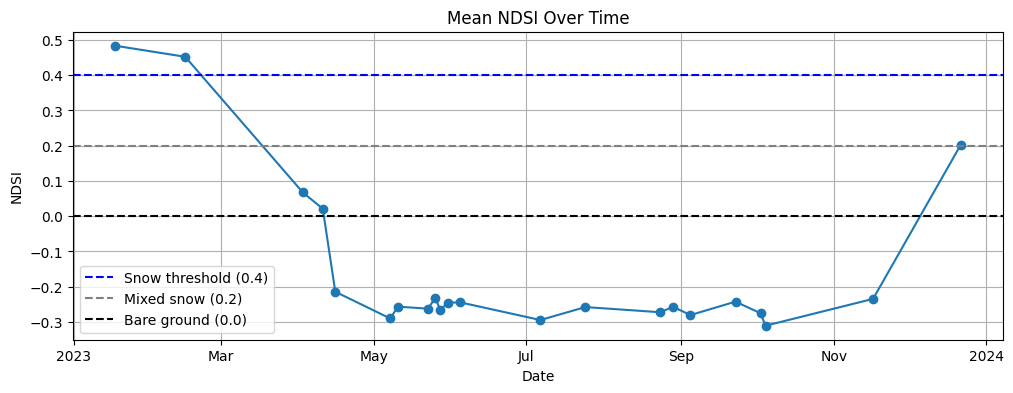

In [22]:
ndsi_timeseries = ndsi_masked.mean(dim=["y", "x"])
ndsi_timeseries.plot(marker="o", figsize=(12, 4))

# Reference lines
plt.axhline(0.4, color="blue", linestyle="--", label="Snow threshold (0.4)")
plt.axhline(0.2, color="gray", linestyle="--", label="Mixed snow (0.2)")
plt.axhline(0.0, color="black", linestyle="--", label="Bare ground (0.0)")

plt.title("Mean NDSI Over Time")
plt.xlabel("Date")
plt.ylabel("NDSI")
plt.legend()
plt.grid(True)
plt.show()

> 🔍 **Note on Gaps in the NDSI Time Series**
>
> Breaks in the line plot occur when scenes are fully masked due to clouds or shadows — resulting in no valid NDSI values for that date.
> These time steps appear as `NaN` in the data and are rendered as gaps in the plot.
>
> This is expected behavior and helps highlight when cloud-free observations were not available for the selected area and time range.

### ❄️ Interpreting NDSI Values

The **Normalized Difference Snow Index (NDSI)** is a powerful tool for identifying snow cover in satellite imagery by comparing reflectance in the green and shortwave infrared (SWIR) bands.  
Snow is typically **bright in the green band** and **absorptive in the SWIR band**, leading to high NDSI values.

#### Thresholds and Uncertainty

Interpreting NDSI values isn't always straightforward — thresholds can vary depending on:
- **land cover** (e.g., forested vs. open terrain),
- **illumination and sensor angle**,
- **scene conditions** (e.g., snow under cloud shadow or mixed with vegetation).

That said, commonly used guidelines include:

| NDSI Value Range | Interpretation                            |
|------------------|--------------------------------------------|
| > **0.4**         | Likely **snow-covered** surface           |
| 0.2 – 0.4         | Possibly **mixed snow** or patchy areas   |
| 0.0 – 0.2         | Bare ground or dry soil                   |
| < **0.0**         | Water, vegetation, or cloud shadow        |

These are not hard rules — think of them as **decision aids** rather than strict classifiers.

In this notebook, we include horizontal reference lines on the NDSI time series plot to help guide interpretation.  
However, if your AOI is forested, coastal, or mountainous, it may be worth adjusting the snow threshold or inspecting example scenes visually for validation.

### 📤 Exporting Results for Use in Power BI

To make the NDSI results available in external tools like Power BI, we can export a simple table summarizing:

- the **date** of each satellite scene,
- the **mean NDSI** value for that date,
- a **classified result** indicating snow presence (e.g., `"snow"`, `"mixed"`, or `"no snow"`).

This table can be saved as a CSV file and uploaded to Power BI or other data analysis platforms for further visualization and reporting.

In [139]:
# Create a DataFrame from the NDSI time series
ndsi_df = ndsi_timeseries.to_dataframe(name="ndsi").reset_index()

# Add a simple classification based on threshold
def classify_ndsi(value):
    if pd.isna(value):
        return "no data"
    elif value > 0.4:
        return "snow"
    elif value > 0.2:
        return "mixed"
    else:
        return "no snow"

ndsi_df["classification"] = ndsi_df["ndsi"].apply(classify_ndsi)

# Export to CSV
ndsi_df.to_csv("ndsi_summary.csv", index=False)

### 📊 Visualizing Results in Power BI

To explore the results interactively within Microsoft’s ecosystem, you can upload the `ndsi_summary.csv` file to [Power BI](https://app.powerbi.com/).  
This allows you to create custom dashboards and visualizations—such as time series plots or spatial summaries—directly from your NDSI data, all within the familiar Microsoft suite.

## ✅ Next Steps

This notebook introduced the core concepts of time-series monitoring using Sentinel-2 imagery and NDSI to detect snow cover over a user-defined area and date range.

To continue exploring site monitoring workflows, check out the next notebook:

👉 **[site-monitoring-hls.ipynb](./site-monitoring-hls.ipynb)**  
This notebook uses HLS (Harmonized Landsat and Sentinel) data to demonstrate cross-sensor monitoring and highlight additional techniques like combining indices and refining temporal analysis.

### 💡 Other ideas to try:
- Use NDVI to monitor vegetation changes before/after snow cover
- Compare results across different years to study seasonal patterns
- Apply thresholds to detect persistent snow vs. transient snowfall
- Export your xarray dataset for visualization in other GIS tools

---

## 📎 Supporting Materials

- [Sentinel-2 STAC collection on Planetary Computer](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a)
- [NDSI overview – USGS](https://www.usgs.gov/landsat-missions/normalized-difference-snow-index)
- [STAC specification](https://stacspec.org/)
- [ODC-STAC documentation](https://odc-stac.readthedocs.io/)
- [Xarray documentation](https://docs.xarray.dev/)